In [1]:
# This block imports modules, randomly separates the data into training / validation / test sets, 
# and defines and evaluates the pretrained model

import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix
import torch.version
from torchvision.models import mobilenet_v3_large
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.utils import make_grid

# This implementation includes a scipy library to directly read .WAV files and uses TorchAudio for structure and transforms


import os
from scipy.io import wavfile
import torchaudio
import torchaudio.transforms as transforms
import soundfile
from torch.nn.utils.rnn import pad_sequence

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # set device to GPU if available
#print(torch.version.cuda)
#print(device)

class AudioDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (str): Directory with all the audio files.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.root_dir = root_dir
        self.file_paths = []
        self.labels = []
        self.transform = transform

        # Walk through directory and collect file paths and labels
        for label in os.listdir(root_dir):
            label_path = os.path.join(root_dir, label)
            if os.path.isdir(label_path):
                for file_name in os.listdir(label_path):
                    if file_name.endswith(".wav"):
                        self.file_paths.append(os.path.join(label_path, file_name))
                        self.labels.append(label)

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        # Load the audio file
        audio_path = self.file_paths[idx]
        waveform, sample_rate = torchaudio.load(audio_path)

        # Convert to mono if it's stereo
        if waveform.size(0) > 1:  # Check if stereo
            waveform = waveform.mean(dim=0, keepdim=True)  # Average channels

        # Get the label
        label = self.labels[idx]
        
        # Apply transformation if specified
        if self.transform:
            waveform = self.transform(waveform)
        
        return waveform.squeeze(0), label

class AudioDataset_WithPadding(Dataset):
    def __init__(self, root_dir, max_length, transform=None):
        """
        Args:
            root_dir (str): Directory with all the audio files.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.root_dir = root_dir
        self.file_paths = []
        self.labels = []
        self.max_length = max_length
        self.transform = transform

        # Walk through directory and collect file paths and labels
        for label in os.listdir(root_dir):
            label_path = os.path.join(root_dir, label)
            if os.path.isdir(label_path):
                for file_name in os.listdir(label_path):
                    if file_name.endswith(".wav"):
                        self.file_paths.append(os.path.join(label_path, file_name))
                        self.labels.append(label)

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        # Load the audio file
        audio_path = self.file_paths[idx]
        waveform, sample_rate = torchaudio.load(audio_path)

        # Convert to mono if it's stereo
        if waveform.size(0) > 1:  # Check if stereo
            waveform = waveform.mean(dim=0, keepdim=True)  # Average channels

        # Pad waveform to the fixed length
        if waveform.size(1) < self.max_length:
            pad_amount = self.max_length - waveform.size(1)
            #print(pad_amount)
            waveform = torch.nn.functional.pad(waveform, (0, pad_amount), "constant", 0)
        
        # Get the label
        label = self.labels[idx]
        if label == "Major":
            label_num = 0
        else:
            label_num = 1
        
        # Apply transformation if specified
        if self.transform:
            waveform = self.transform(waveform)
            #print(waveform.size(2))

        return waveform, label, label_num


transform = transforms.MelSpectrogram(sample_rate=16000, n_mels=64)

root_dir = "data/"

dataset_temp = AudioDataset(root_dir) # Create dataset from major / minor chords folders (chords are organized in folders by chord type)

waveforms = [dataset_temp[i][0] for i in range(len(dataset_temp))]

max_length = 0
for i, waveform in enumerate(waveforms):
    if (int(waveform.shape[0])) > max_length:
        max_length = int(waveform.shape[0])

dataset = AudioDataset_WithPadding(root_dir, max_length=max_length, transform=transform) # Create dataset from major / minor chords folders (chords are organized in folders by chord type)

waveforms = [dataset[i][0] for i in range(len(dataset))]

data_loader = torch.utils.data.DataLoader(dataset, batch_size = 1, shuffle=True) # Load Dataset

for batch in data_loader:
    waveforms, labels, labels_num = batch

num_data = len(dataset) # Total Number of Data Points in Dataset

train_size = int(0.7*num_data) # Allocate 70% of Data Points for Training
val_size = int(0.15*num_data) # Allocate 15% of Data Points for Validation Set
test_size = num_data - train_size - val_size # Allocate Remaining Data Points (15%) for Test Set

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size]) # Use random_split to randomly separate the dataset into training, validation, testing sets

train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True) # training data loader with randomization and batch size 10
val_loader = DataLoader(val_dataset, batch_size=10, shuffle=False) # validation data loader with no randomization and batch size 10
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False) # test data loader with no randomization and batch size 10

num_class = 2
model_pretrained = mobilenet_v3_large(pretrained=True)
model_pretrained.classifier[3] = nn.Sequential(
    nn.Dropout(0.5), # implement dropout rate of 50% to discourage overfitting
    nn.Linear(model_pretrained.classifier[3].in_features, num_class)
)

model_pretrained.features[0][0] = nn.Conv2d(
    in_channels=1,  # Change to 1 for single-channel input
    out_channels=16,  # Keep the same as original
    kernel_size=3,
    stride=2,
    padding=1,
    bias=False
)

num_major = 0
num_minor = 0

# Get count of major / minor chords in training set

for waveform, label, label_num in train_dataset:
    if label_num == 0:
        num_major += 1
    else:
        num_minor += 1

class_ns = torch.tensor([num_major, num_minor])
weights = 1.0 / class_ns
weights = weights / weights.sum()

criter = nn.CrossEntropyLoss(weight=weights)

model_pretrained.to(device) # move pretrained model to GPU

def visualize_hook(module, input, output):
    activation = output.squeeze(0) # find activations of layer, remove zeroes
    activation = activation.unsqueeze(1) # remove ones from activation tensor to match image characteristics

    grid = make_grid(activation, nrow=8, normalize=True, scale_each = True) # create grid using make_grid from activations
    
    plt.figure(figsize=(15, 15))
    for i in range(output.size(1)):
        #plt.subplot(8, 8, i + 1)
        plt.imshow(grid.permute(1,2,0).cpu().numpy(), cmap="gray") # show image with grid in grayscale
        #plt.imshow(output[0,i].detach().cpu().numpy(), cmap="gray")
        plt.axis("off")
    plt.show()
# Choose a specific layer and register the hook
#layer_to_visualize = model_pretrained.conv1 # show convolutional layer 1
#hook = layer_to_visualize.register_forward_hook(visualize_hook)

#index = torch.randint(0,test_size-1,(1,)) # generate random index in range of test data set
#print(index)
#image, label = test_dataset[index] # image, label of selected random test image
#image = image.resize(3,224,224)
#image = image.unsqueeze(0).to(device) # move image to GPU


model_pretrained.eval()

#_ = model_pretrained(image)
#hook.remove() # Remove the hook



outputs_list = []
correct = 0
total = 0
loss_pretrained = 0
with torch.no_grad():
    for waveforms, labels, labels_num in test_loader:
        waveforms, labels_num = waveforms.to(device), labels_num.to(device)
        #images, labels = images.to(device), labels.to(device)
        #print(images.shape)
        outputs = model_pretrained(waveforms)
        _, predicted = torch.max(outputs, 1)
        total+= len(labels)
        #batch_labels = []
        for i in range(len(labels_num)):
            if labels_num[i] == predicted[i]:
                correct+=1
        #print(batch_labels)
        #correct+= (predicted == batch_labels).sum().item()
        outputs_list.append(outputs)
        #batch_labels = torch.tensor(batch_labels)
        #print(batch_labels)
        loss = criter(outputs,labels_num)
        loss_pretrained += loss.item() * waveforms.size(0)
        

print("{}% Test Accuracy With Pre-Trained Model".format(correct/total*100))
print("Test Set Loss of {} With Pre-Trained Model".format(loss_pretrained))




C:\Users\sk3ll\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\sk3ll\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


50.76923076923077% Test Accuracy With Pre-Trained Model
Test Set Loss of 89.22282218933105 With Pre-Trained Model


Training Model with Fully Connected (Output) Layer Unfrozen:

Epoch 1/10:

Training Loss For Epoch 1: 0.7321211985264364
Training Accuracy After Epoch 1: 47.92%

Validation Loss For Epoch 1: 0.6938202772289515
Validation Accuracy After Epoch 1: 52.34%

Epoch 2/10:

Training Loss For Epoch 2: 0.698607607213114
Training Accuracy After Epoch 2: 53.58%

Validation Loss For Epoch 2: 0.6852110680192709
Validation Accuracy After Epoch 2: 58.59%

Epoch 3/10:

Training Loss For Epoch 3: 0.7135345486555242
Training Accuracy After Epoch 3: 51.25%

Validation Loss For Epoch 3: 0.689776306040585
Validation Accuracy After Epoch 3: 54.69%

Epoch 4/10:

Training Loss For Epoch 4: 0.6949216393186725
Training Accuracy After Epoch 4: 53.91%

Validation Loss For Epoch 4: 0.6893149027600884
Validation Accuracy After Epoch 4: 58.59%

Epoch 5/10:

Training Loss For Epoch 5: 0.7000275885999302
Training Accuracy After Epoch 5: 53.91%

Validation Loss For Epoch 5: 0.6998760774731636
Validation Accuracy After Ep

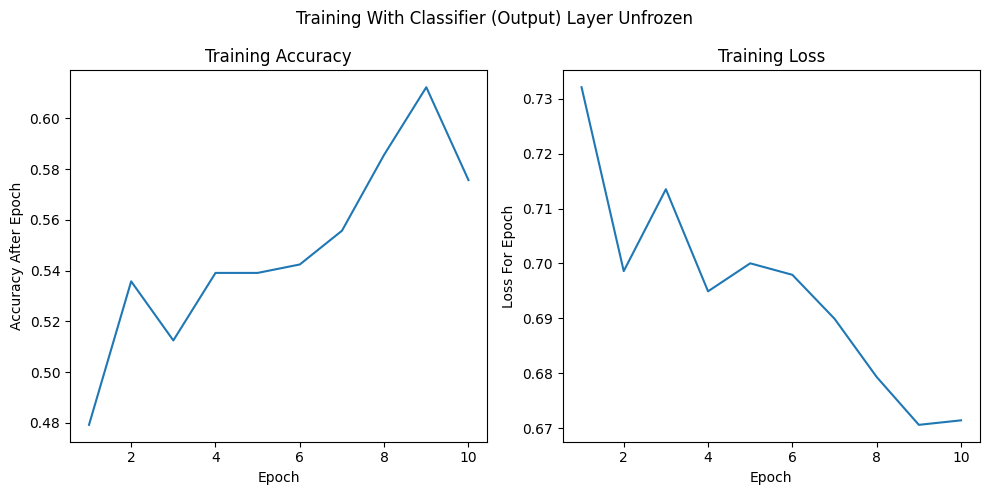

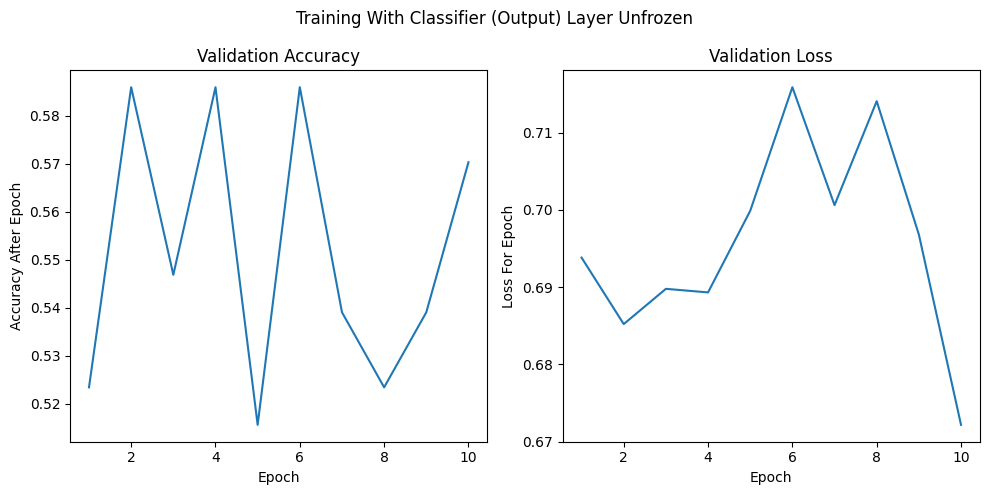

In [2]:
# This block fine-tunes the fully connected output layer of the model, beginning with the pretrained ResNet-34 model

import torch.optim as optim

model = mobilenet_v3_large(pretrained=True)
model.classifier[3] = nn.Sequential(
    nn.Dropout(0.5), # implement dropout rate of 50% to discourage overfitting
    nn.Linear(model.classifier[3].in_features, num_class)
)

model.features[0][0] = nn.Conv2d(
    in_channels=1,  # Change to 1 for single-channel input
    out_channels=16,  # Keep the same as original
    kernel_size=3,
    stride=2,
    padding=1,
    bias=False
)

model = model.to(device) # move model to GPU

for param in model.parameters(): # freeze all model parameters
    param.requires_grad = False
for param in model.classifier[3].parameters(): # unfreeze fully connected layer
    param.requires_grad = True



criter = nn.CrossEntropyLoss(weight=weights) # Cross-Entropy Loss Function
optimizer = optim.Adam(model.classifier[3].parameters(), lr=1e-4) # Adam optimizer with learning rate 1e-4 to start training

num_epoch = 10 # 10 epochs

def train_model(model, dataloader, criter, optimizer, num_epoch = 5):

    train_acc = [] # list of training accuracies during this training
    train_losses = [] # list of training losses during this training
    val_acc = [] # list of validation accuracies during this training 
    val_losses = [] # list of validation losses during this training
    
    for epoch in range(num_epoch):
        print("Epoch {}/{}:\n".format(epoch+1,num_epoch)) 

        model.train() # set model to training mode
        train_loss = 0 # training loss running total starts at zero
        train_correct = 0 # correctly classified images from training set running total starts at zero
        val_loss = 0 # validation loss running total starts at zero
        val_correct = 0 # correctly classified images from validation set running total starts at zero

        for inputs, labels, labels_num in dataloader["train"]:
            inputs, labels_num = inputs.to(device), labels_num.to(device) # move inputs (images) and labels to GPU

            optimizer.zero_grad()
            outputs = model(inputs) # feed forward
            _, class_preds_train = torch.max(outputs,1) # predict classes based on model output
            loss = criter(outputs,labels_num) # generate loss values

            loss.backward() # backpropagate
            optimizer.step()

            train_loss += loss.item() * inputs.size(0) # add loss from this epoch to training loss
            train_correct += torch.sum(class_preds_train == labels_num.data) # add correctly classified images count to total correctly classified for training set

        train_loss_epoch = train_loss / len(dataloader["train"].dataset) # training loss this epoch
        train_losses.append(train_loss_epoch) # add training loss this epoch to list of training losses
        train_acc_epoch = train_correct / len(dataloader["train"].dataset) # training accuracy this epoch
        train_acc.append(train_acc_epoch) # add training accuracy this epoch to list of training accuracies

        for inputs, labels, labels_num in dataloader["val"]: # performs same loss / accuracy calculations as training set for validation set
            inputs, labels_num = inputs.to(device), labels_num.to(device) 
            
            outputs = model(inputs)
            _, class_preds_val = torch.max(outputs, 1)
            loss = criter(outputs,labels_num)

            # Do not backpropagate - no training on validation set
            
            val_loss += loss.item() * inputs.size(0)
            val_correct += torch.sum(class_preds_val == labels_num.data)

        val_loss_epoch = val_loss / len(dataloader["val"].dataset)
        val_losses.append(val_loss_epoch)
        val_acc_epoch = val_correct / len(dataloader["val"].dataset)
        val_acc.append(val_acc_epoch)

        print("Training Loss For Epoch {}: {}".format(epoch+1, train_loss_epoch))
        print("Training Accuracy After Epoch {}: {:.2f}%\n".format(epoch+1, train_acc_epoch*100))

        print("Validation Loss For Epoch {}: {}".format(epoch+1, val_loss_epoch))
        print("Validation Accuracy After Epoch {}: {:.2f}%\n".format(epoch+1, val_acc_epoch*100))
    
    return model, train_acc, train_losses, val_acc, val_losses
    
print("Training Model with Fully Connected (Output) Layer Unfrozen:\n")
dataloader = {"train": train_loader, "val": val_loader}
model, train_acc, train_losses, val_acc, val_losses = train_model(model, dataloader, criter, optimizer, num_epoch)

def plot_learning(num_epoch, accuracy, loss, layer_description, dataset='Train'):

    if dataset == 'train':
        dataset = "Training"
    if dataset == 'val':
        dataset = "Validation"
    acc_cpu = []
    loss_cpu = []

    # Move accuracy and loss tensors to CPU for numpy use
    for i in range(len(accuracy)):
        acc_cpu.append(accuracy[i].clone().detach().cpu())
        loss_cpu.append(loss[i])
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5)) # create two subplots

    x = []
    for i in range(num_epoch):
        x.append(i+1) # Create list for X values from 0 to num_epoch for plotting

    # Plotting Accuracy vs Epoch
    ax1.plot(x, acc_cpu)
    ax1.set_title('{} Accuracy'.format(dataset))
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy After Epoch')

    # Plotting Loss vs Epoch
    ax2.plot(x, loss_cpu)
    ax2.set_title('{} Loss'.format(dataset))
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss For Epoch')

    plt.suptitle(layer_description)
    plt.tight_layout()

    plt.show()
    
layer_description = "Training With Classifier (Output) Layer Unfrozen"
plot_learning(num_epoch, train_acc, train_losses, layer_description, dataset="train")
plot_learning(num_epoch, val_acc, val_losses, layer_description, dataset="val")

Training Model with Classifier (Output) Layer and Next 1 Layers Unfrozen:

Epoch 1/10:

Training Loss For Epoch 1: 0.6795166875677379
Training Accuracy After Epoch 1: 56.91%

Validation Loss For Epoch 1: 0.6858706781640649
Validation Accuracy After Epoch 1: 53.12%

Epoch 2/10:

Training Loss For Epoch 2: 0.6832679514083608
Training Accuracy After Epoch 2: 56.41%

Validation Loss For Epoch 2: 0.6913880873471498
Validation Accuracy After Epoch 2: 55.47%

Epoch 3/10:

Training Loss For Epoch 3: 0.6817564001297594
Training Accuracy After Epoch 3: 60.07%

Validation Loss For Epoch 3: 0.7094450006261468
Validation Accuracy After Epoch 3: 56.25%

Epoch 4/10:

Training Loss For Epoch 4: 0.6642009718049188
Training Accuracy After Epoch 4: 60.90%

Validation Loss For Epoch 4: 0.6946780984289944
Validation Accuracy After Epoch 4: 48.44%

Epoch 5/10:

Training Loss For Epoch 5: 0.6621138692497215
Training Accuracy After Epoch 5: 61.73%

Validation Loss For Epoch 5: 0.7086823601275682
Validation Ac

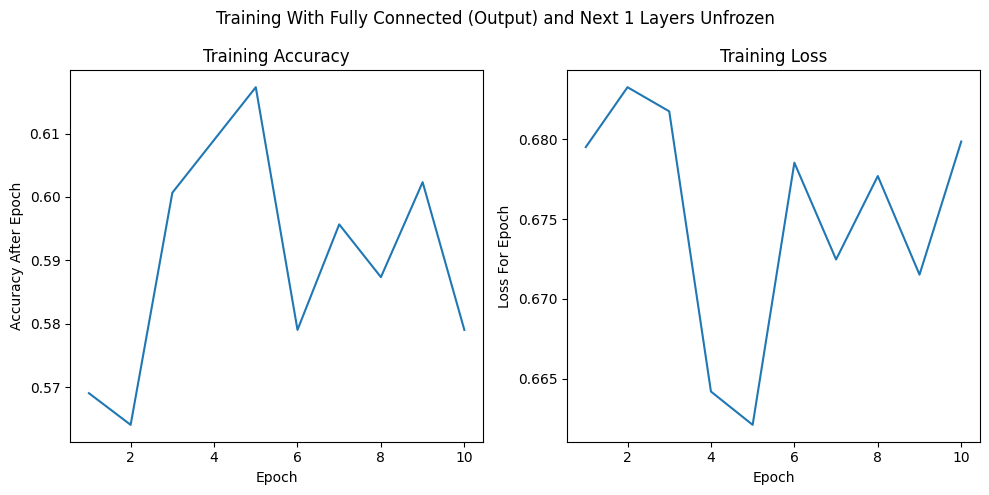

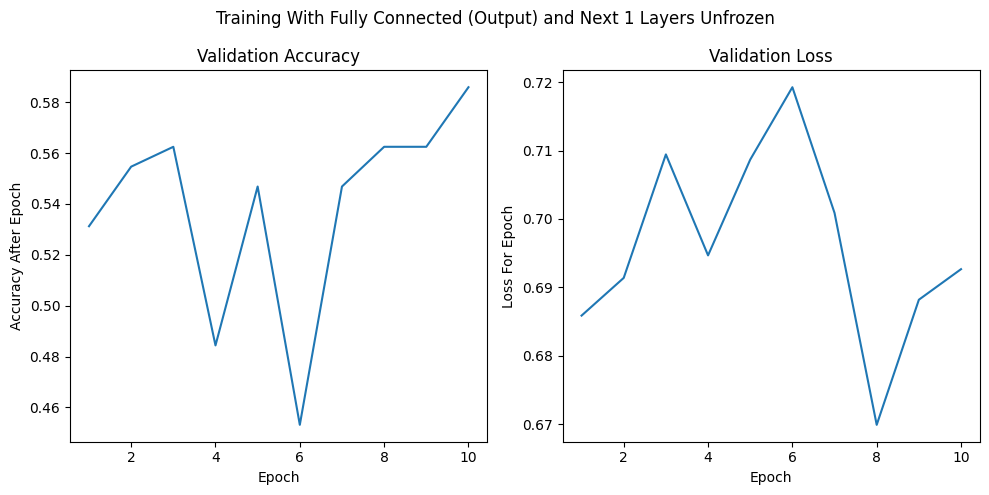

Training Model with Classifier (Output) Layer and Next 2 Layers Unfrozen:

Epoch 1/10:

Training Loss For Epoch 1: 0.6660246952202872
Training Accuracy After Epoch 1: 61.56%

Validation Loss For Epoch 1: 0.7039102073758841
Validation Accuracy After Epoch 1: 49.22%

Epoch 2/10:

Training Loss For Epoch 2: 0.6706872193666544
Training Accuracy After Epoch 2: 59.23%

Validation Loss For Epoch 2: 0.6633354127407074
Validation Accuracy After Epoch 2: 59.38%

Epoch 3/10:

Training Loss For Epoch 3: 0.6666881112806412
Training Accuracy After Epoch 3: 59.23%

Validation Loss For Epoch 3: 0.7004702659323812
Validation Accuracy After Epoch 3: 57.03%

Epoch 4/10:

Training Loss For Epoch 4: 0.6755740535933642
Training Accuracy After Epoch 4: 59.23%

Validation Loss For Epoch 4: 0.7106425538659096
Validation Accuracy After Epoch 4: 57.03%

Epoch 5/10:

Training Loss For Epoch 5: 0.669217036885152
Training Accuracy After Epoch 5: 57.90%

Validation Loss For Epoch 5: 0.6755753578618169
Validation Acc

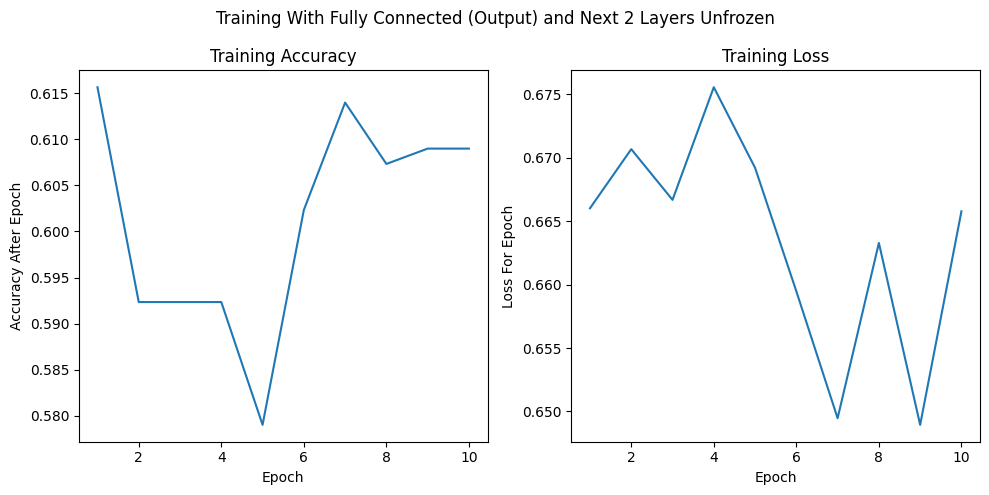

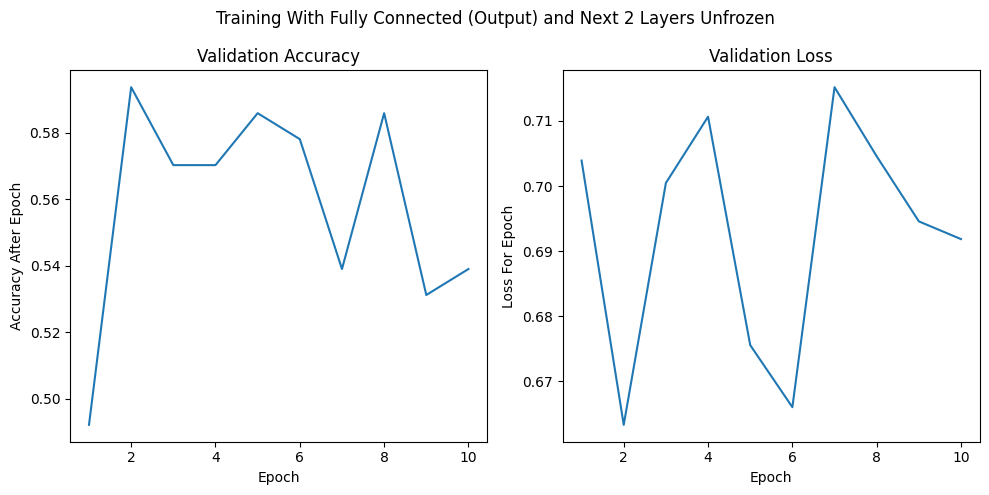

Training Model with Classifier (Output) Layer and Next 3 Layers Unfrozen:

Epoch 1/10:

Training Loss For Epoch 1: 0.6808307769889641
Training Accuracy After Epoch 1: 57.07%

Validation Loss For Epoch 1: 0.7189461104571819
Validation Accuracy After Epoch 1: 50.78%

Epoch 2/10:

Training Loss For Epoch 2: 0.6780031131031906
Training Accuracy After Epoch 2: 58.74%

Validation Loss For Epoch 2: 0.6832237625494599
Validation Accuracy After Epoch 2: 58.59%

Epoch 3/10:

Training Loss For Epoch 3: 0.6646465889229354
Training Accuracy After Epoch 3: 59.57%

Validation Loss For Epoch 3: 0.699206531047821
Validation Accuracy After Epoch 3: 55.47%

Epoch 4/10:

Training Loss For Epoch 4: 0.6659063026432983
Training Accuracy After Epoch 4: 60.73%

Validation Loss For Epoch 4: 0.6877528689801693
Validation Accuracy After Epoch 4: 60.16%

Epoch 5/10:

Training Loss For Epoch 5: 0.6642056929688287
Training Accuracy After Epoch 5: 61.73%

Validation Loss For Epoch 5: 0.7065396457910538
Validation Acc

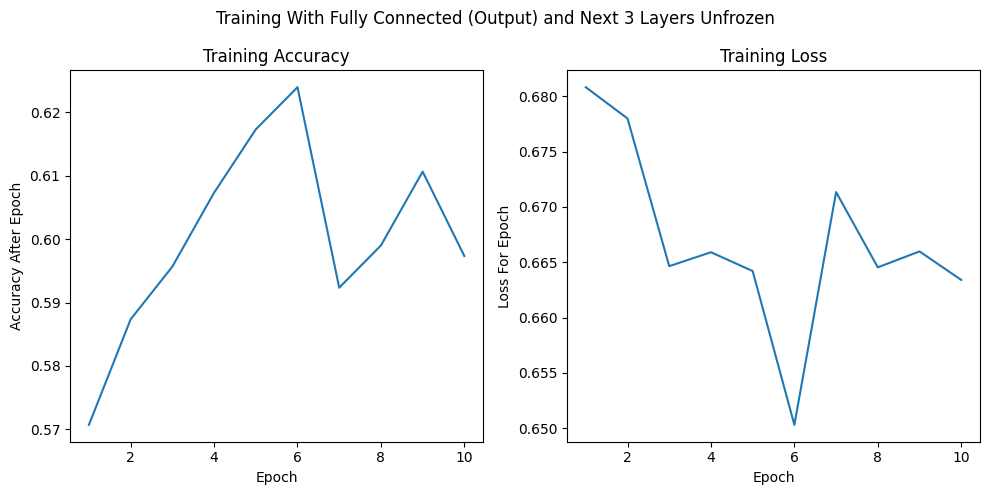

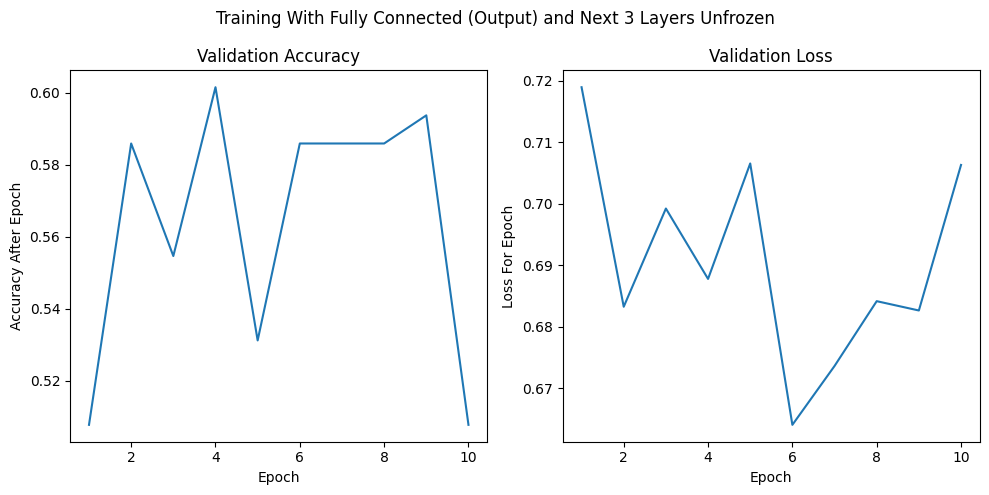

Training Model with Classifier (Output) Layer and Next 4 Layers Unfrozen:

Epoch 1/10:

Training Loss For Epoch 1: 0.6562611640193895
Training Accuracy After Epoch 1: 61.40%

Validation Loss For Epoch 1: 0.6980752982199192
Validation Accuracy After Epoch 1: 51.56%

Epoch 2/10:

Training Loss For Epoch 2: 0.6485759200351607
Training Accuracy After Epoch 2: 63.89%

Validation Loss For Epoch 2: 0.7017250237986445
Validation Accuracy After Epoch 2: 52.34%

Epoch 3/10:

Training Loss For Epoch 3: 0.6532955920438401
Training Accuracy After Epoch 3: 61.90%

Validation Loss For Epoch 3: 0.6850837785750628
Validation Accuracy After Epoch 3: 57.03%

Epoch 4/10:

Training Loss For Epoch 4: 0.6526871254162463
Training Accuracy After Epoch 4: 62.40%

Validation Loss For Epoch 4: 0.6776633756235242
Validation Accuracy After Epoch 4: 58.59%

Epoch 5/10:

Training Loss For Epoch 5: 0.6487448002256688
Training Accuracy After Epoch 5: 62.56%

Validation Loss For Epoch 5: 0.6907525034621358
Validation Ac

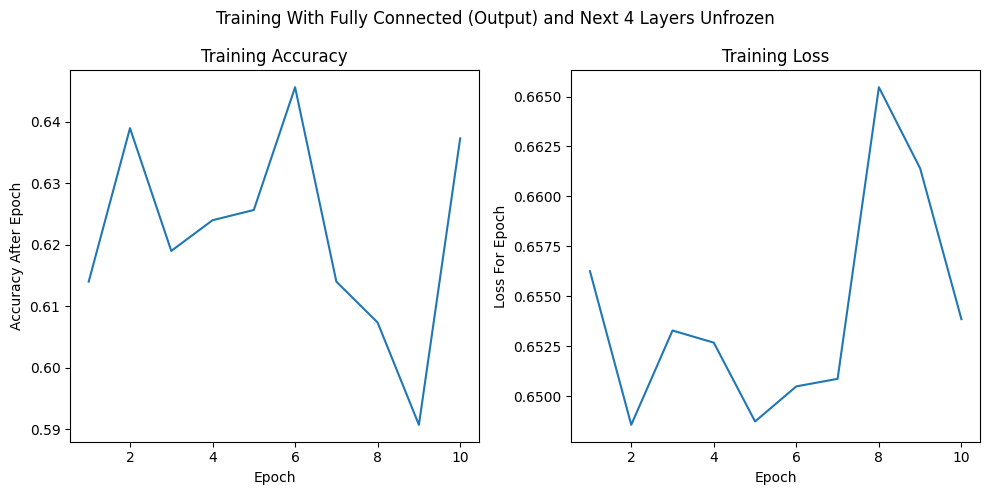

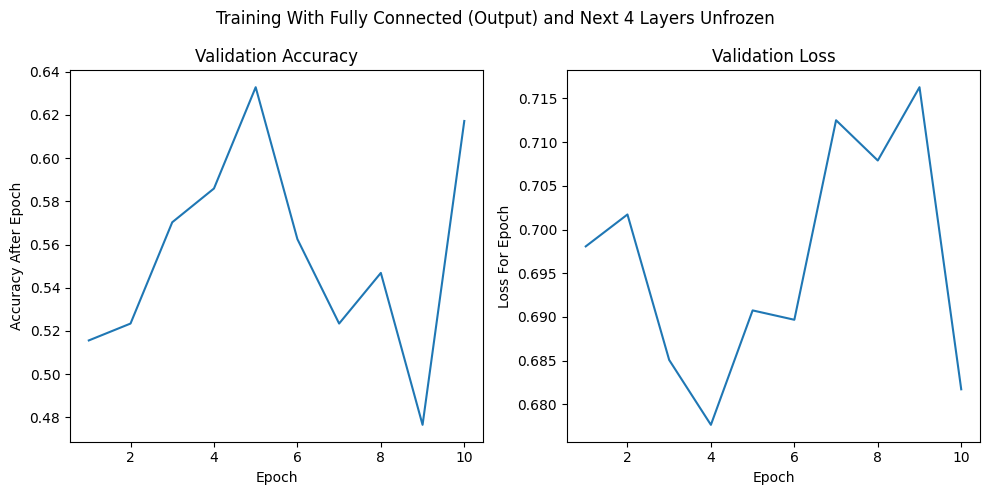

Training Model with Classifier (Output) Layer and Next 5 Layers Unfrozen:

Epoch 1/10:

Training Loss For Epoch 1: 0.662002186707768
Training Accuracy After Epoch 1: 60.73%

Validation Loss For Epoch 1: 0.7169105354696512
Validation Accuracy After Epoch 1: 55.47%

Epoch 2/10:

Training Loss For Epoch 2: 0.642305270506816
Training Accuracy After Epoch 2: 63.73%

Validation Loss For Epoch 2: 0.6622923212125897
Validation Accuracy After Epoch 2: 61.72%

Epoch 3/10:

Training Loss For Epoch 3: 0.6557495840972355
Training Accuracy After Epoch 3: 62.56%

Validation Loss For Epoch 3: 0.7000118410214782
Validation Accuracy After Epoch 3: 54.69%

Epoch 4/10:

Training Loss For Epoch 4: 0.64355917520412
Training Accuracy After Epoch 4: 65.72%

Validation Loss For Epoch 4: 0.7067889934405684
Validation Accuracy After Epoch 4: 53.12%

Epoch 5/10:

Training Loss For Epoch 5: 0.6426988332323147
Training Accuracy After Epoch 5: 64.39%

Validation Loss For Epoch 5: 0.7096915952861309
Validation Accura

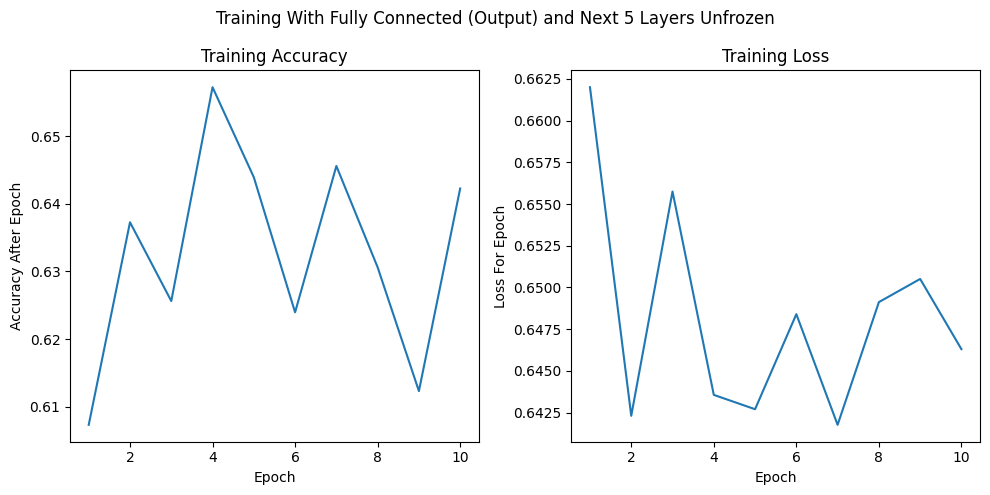

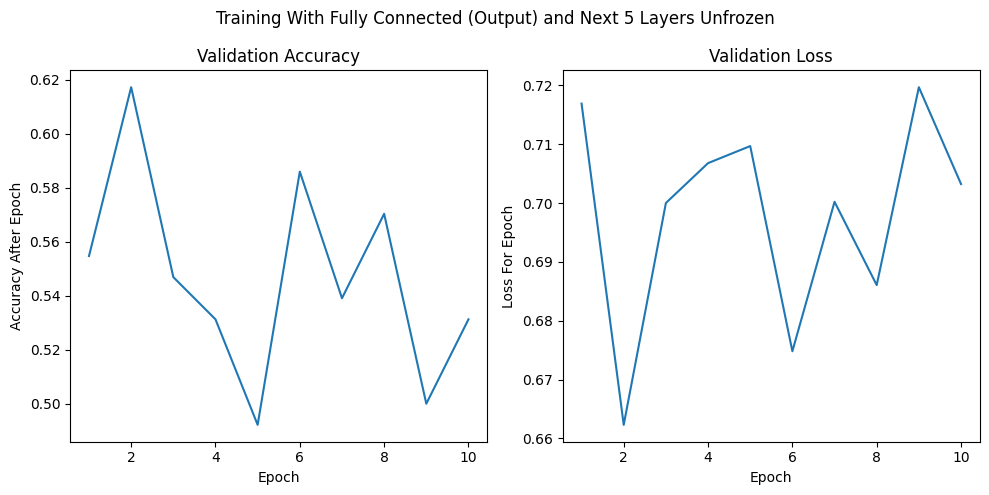

Training Model with Classifier (Output) Layer and Next 6 Layers Unfrozen:

Epoch 1/10:

Training Loss For Epoch 1: 0.6479545655147406
Training Accuracy After Epoch 1: 62.73%

Validation Loss For Epoch 1: 0.7119162743911147
Validation Accuracy After Epoch 1: 52.34%

Epoch 2/10:

Training Loss For Epoch 2: 0.6464878010273774
Training Accuracy After Epoch 2: 62.90%

Validation Loss For Epoch 2: 0.6806639563292265
Validation Accuracy After Epoch 2: 55.47%

Epoch 3/10:

Training Loss For Epoch 3: 0.6647558150791288
Training Accuracy After Epoch 3: 59.90%

Validation Loss For Epoch 3: 0.6916249645873904
Validation Accuracy After Epoch 3: 53.91%

Epoch 4/10:

Training Loss For Epoch 4: 0.6482573837884849
Training Accuracy After Epoch 4: 62.23%

Validation Loss For Epoch 4: 0.6781136598438025
Validation Accuracy After Epoch 4: 52.34%

Epoch 5/10:

Training Loss For Epoch 5: 0.639318515427299
Training Accuracy After Epoch 5: 63.23%

Validation Loss For Epoch 5: 0.7012557433918118
Validation Acc

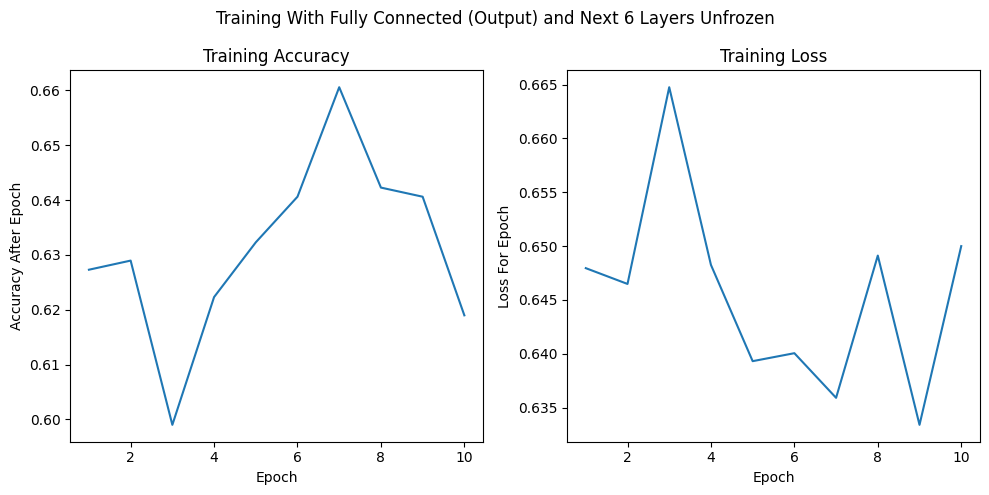

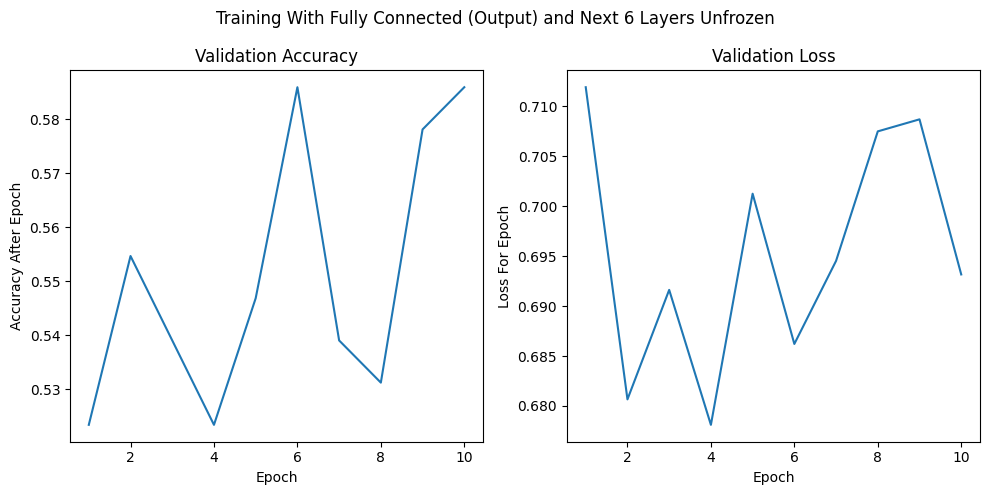

Training Model with Classifier (Output) Layer and Next 7 Layers Unfrozen:

Epoch 1/10:

Training Loss For Epoch 1: 0.6432142068264687
Training Accuracy After Epoch 1: 62.73%

Validation Loss For Epoch 1: 0.7025381717830896
Validation Accuracy After Epoch 1: 50.00%

Epoch 2/10:

Training Loss For Epoch 2: 0.6372399040545877
Training Accuracy After Epoch 2: 62.56%

Validation Loss For Epoch 2: 0.6988977584987879
Validation Accuracy After Epoch 2: 53.91%

Epoch 3/10:

Training Loss For Epoch 3: 0.6309184222768824
Training Accuracy After Epoch 3: 66.39%

Validation Loss For Epoch 3: 0.7132836133241653
Validation Accuracy After Epoch 3: 52.34%

Epoch 4/10:

Training Loss For Epoch 4: 0.6353491994981559
Training Accuracy After Epoch 4: 64.89%

Validation Loss For Epoch 4: 0.7011653929948807
Validation Accuracy After Epoch 4: 57.03%

Epoch 5/10:

Training Loss For Epoch 5: 0.6403140299728826
Training Accuracy After Epoch 5: 62.23%

Validation Loss For Epoch 5: 0.6824221033602953
Validation Ac

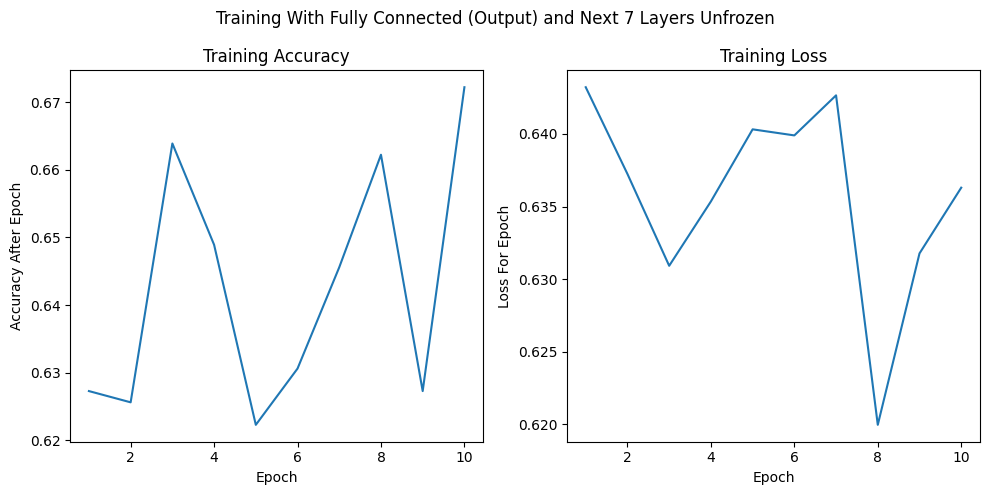

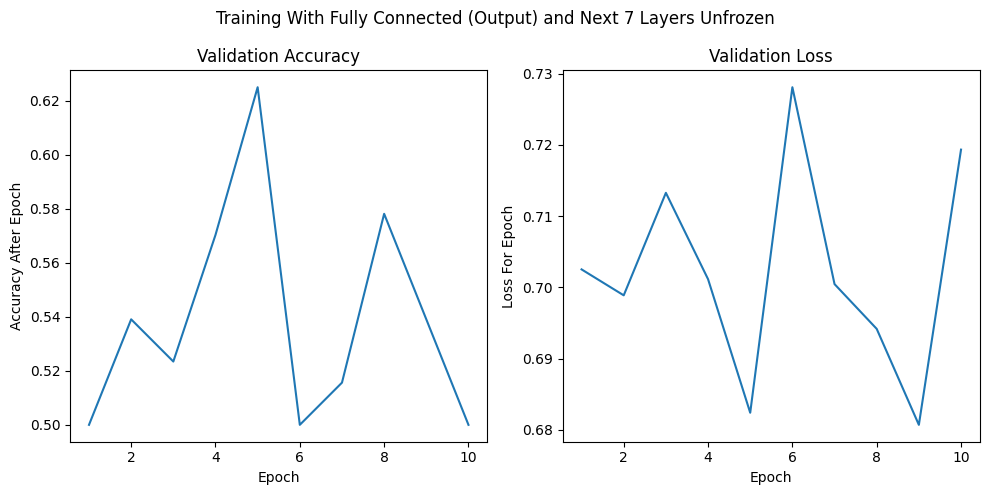

Training Model with Classifier (Output) Layer and Next 8 Layers Unfrozen:

Epoch 1/10:

Training Loss For Epoch 1: 0.6199669122894275
Training Accuracy After Epoch 1: 65.72%

Validation Loss For Epoch 1: 0.6998172299936414
Validation Accuracy After Epoch 1: 56.25%

Epoch 2/10:

Training Loss For Epoch 2: 0.6227185956253585
Training Accuracy After Epoch 2: 65.06%

Validation Loss For Epoch 2: 0.7365382257848978
Validation Accuracy After Epoch 2: 50.78%

Epoch 3/10:

Training Loss For Epoch 3: 0.6111031338299768
Training Accuracy After Epoch 3: 68.05%

Validation Loss For Epoch 3: 0.6999512612819672
Validation Accuracy After Epoch 3: 52.34%

Epoch 4/10:

Training Loss For Epoch 4: 0.6163242419626868
Training Accuracy After Epoch 4: 68.72%

Validation Loss For Epoch 4: 0.7285938495770097
Validation Accuracy After Epoch 4: 46.09%

Epoch 5/10:

Training Loss For Epoch 5: 0.6313237908874296
Training Accuracy After Epoch 5: 64.73%

Validation Loss For Epoch 5: 0.7004231372848153
Validation Ac

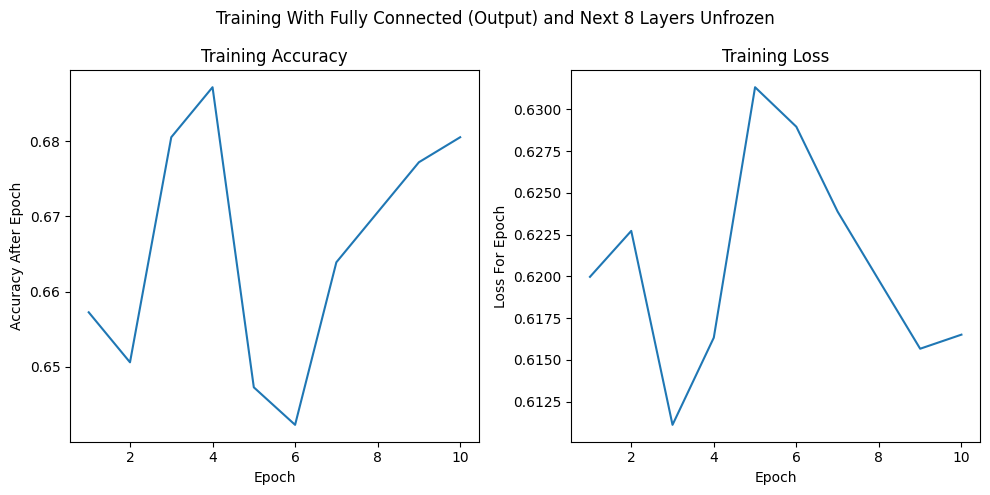

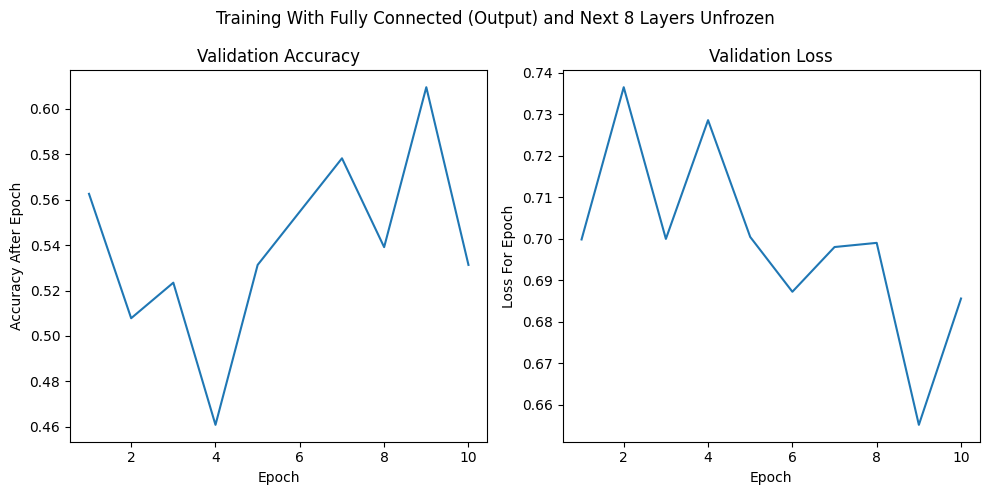

Training Model with Classifier (Output) Layer and Next 9 Layers Unfrozen:

Epoch 1/10:

Training Loss For Epoch 1: 0.6103422584232197
Training Accuracy After Epoch 1: 68.89%

Validation Loss For Epoch 1: 0.6745060868561268
Validation Accuracy After Epoch 1: 60.16%

Epoch 2/10:

Training Loss For Epoch 2: 0.6272581328766517
Training Accuracy After Epoch 2: 66.89%

Validation Loss For Epoch 2: 0.6843934077769518
Validation Accuracy After Epoch 2: 60.94%

Epoch 3/10:

Training Loss For Epoch 3: 0.6179561732017657
Training Accuracy After Epoch 3: 65.89%

Validation Loss For Epoch 3: 0.6422548778355122
Validation Accuracy After Epoch 3: 67.19%

Epoch 4/10:

Training Loss For Epoch 4: 0.6036740720966295
Training Accuracy After Epoch 4: 67.89%

Validation Loss For Epoch 4: 0.6444309875369072
Validation Accuracy After Epoch 4: 64.06%

Epoch 5/10:

Training Loss For Epoch 5: 0.5992893866215292
Training Accuracy After Epoch 5: 69.05%

Validation Loss For Epoch 5: 0.6633643666282296
Validation Ac

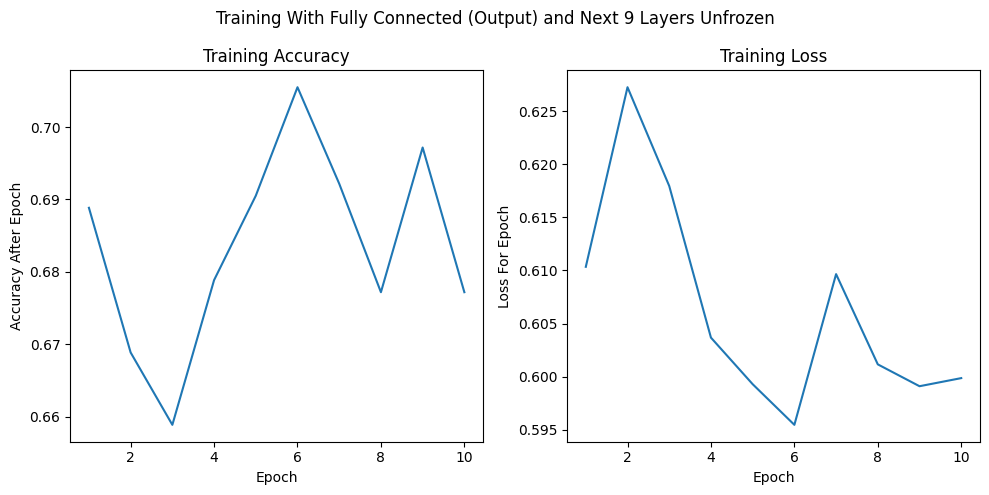

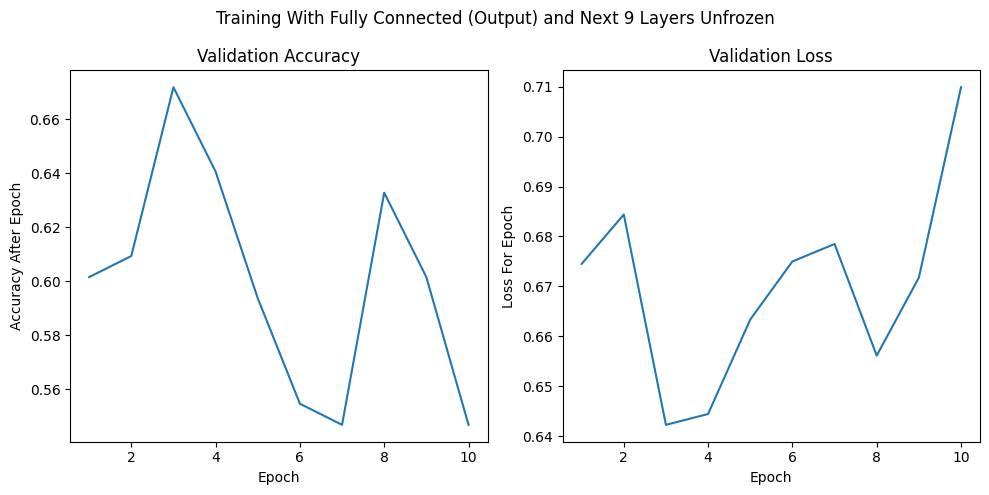

Training Model with Classifier (Output) Layer and Next 10 Layers Unfrozen:

Epoch 1/10:

Training Loss For Epoch 1: 0.598672899549297
Training Accuracy After Epoch 1: 69.22%

Validation Loss For Epoch 1: 0.6751887770369649
Validation Accuracy After Epoch 1: 57.81%

Epoch 2/10:

Training Loss For Epoch 2: 0.6010344521376535
Training Accuracy After Epoch 2: 69.72%

Validation Loss For Epoch 2: 0.6417819568887353
Validation Accuracy After Epoch 2: 60.16%

Epoch 3/10:

Training Loss For Epoch 3: 0.6017430118237082
Training Accuracy After Epoch 3: 70.55%

Validation Loss For Epoch 3: 0.6675027403980494
Validation Accuracy After Epoch 3: 60.16%

Epoch 4/10:

Training Loss For Epoch 4: 0.5747440906114467
Training Accuracy After Epoch 4: 72.05%

Validation Loss For Epoch 4: 0.6779062896966934
Validation Accuracy After Epoch 4: 60.94%

Epoch 5/10:

Training Loss For Epoch 5: 0.5712035278512316
Training Accuracy After Epoch 5: 75.04%

Validation Loss For Epoch 5: 0.6702586123719811
Validation Ac

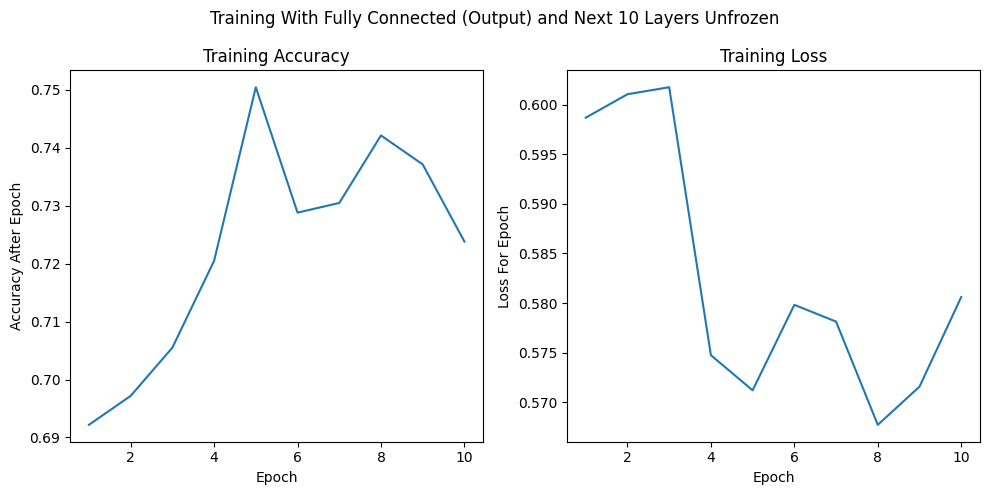

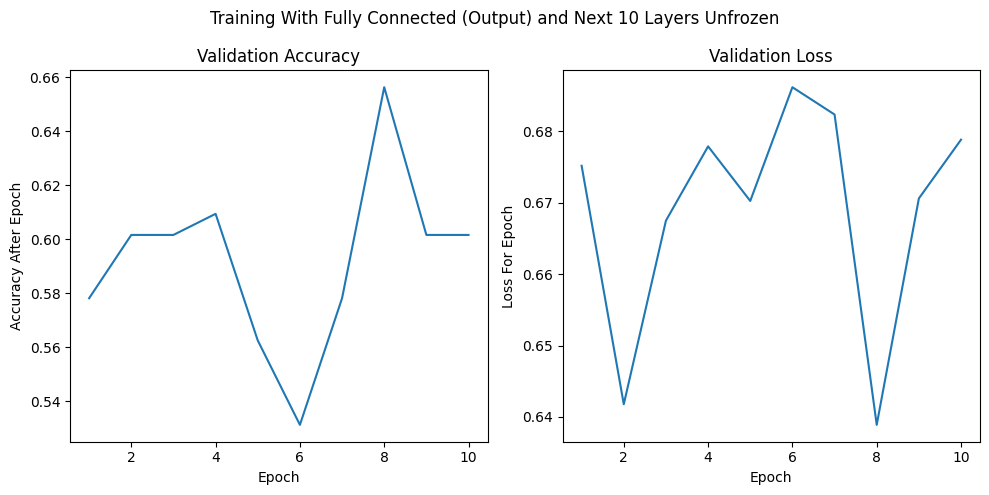

Training Model with Classifier (Output) Layer and Next 11 Layers Unfrozen:

Epoch 1/10:

Training Loss For Epoch 1: 0.5877745245736768
Training Accuracy After Epoch 1: 71.71%

Validation Loss For Epoch 1: 0.6755562531761825
Validation Accuracy After Epoch 1: 59.38%

Epoch 2/10:

Training Loss For Epoch 2: 0.5653929765926621
Training Accuracy After Epoch 2: 73.71%

Validation Loss For Epoch 2: 0.668076338712126
Validation Accuracy After Epoch 2: 60.94%

Epoch 3/10:

Training Loss For Epoch 3: 0.5743764643859546
Training Accuracy After Epoch 3: 72.71%

Validation Loss For Epoch 3: 0.6845652600750327
Validation Accuracy After Epoch 3: 57.03%

Epoch 4/10:

Training Loss For Epoch 4: 0.5639219469516329
Training Accuracy After Epoch 4: 75.37%

Validation Loss For Epoch 4: 0.6725710211321712
Validation Accuracy After Epoch 4: 60.16%

Epoch 5/10:

Training Loss For Epoch 5: 0.5610674408430267
Training Accuracy After Epoch 5: 73.54%

Validation Loss For Epoch 5: 0.6613425225950778
Validation Ac

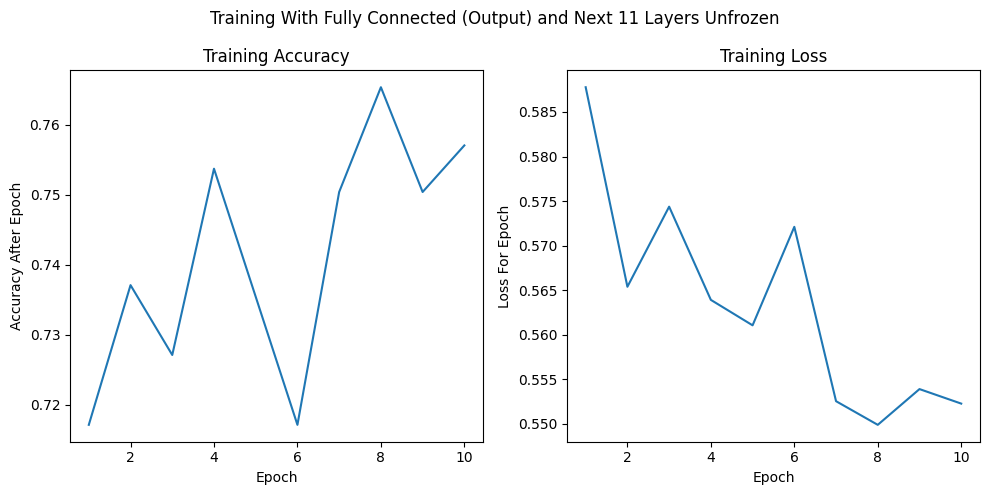

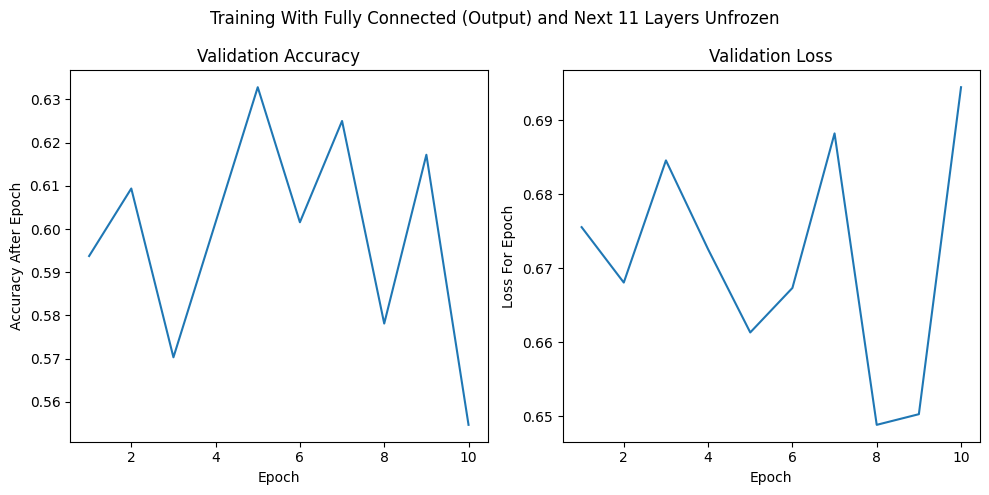

Training Model with Classifier (Output) Layer and Next 12 Layers Unfrozen:

Epoch 1/10:

Training Loss For Epoch 1: 0.5680115819969114
Training Accuracy After Epoch 1: 72.05%

Validation Loss For Epoch 1: 0.6722783762961626
Validation Accuracy After Epoch 1: 62.50%

Epoch 2/10:

Training Loss For Epoch 2: 0.5729564864702907
Training Accuracy After Epoch 2: 70.72%

Validation Loss For Epoch 2: 0.6265909471549094
Validation Accuracy After Epoch 2: 67.97%

Epoch 3/10:

Training Loss For Epoch 3: 0.5556187443249238
Training Accuracy After Epoch 3: 76.21%

Validation Loss For Epoch 3: 0.6558140097185969
Validation Accuracy After Epoch 3: 58.59%

Epoch 4/10:

Training Loss For Epoch 4: 0.5454643664264838
Training Accuracy After Epoch 4: 75.87%

Validation Loss For Epoch 4: 0.6482869628816843
Validation Accuracy After Epoch 4: 57.81%

Epoch 5/10:

Training Loss For Epoch 5: 0.5240474558511312
Training Accuracy After Epoch 5: 78.20%

Validation Loss For Epoch 5: 0.6419101902283728
Validation A

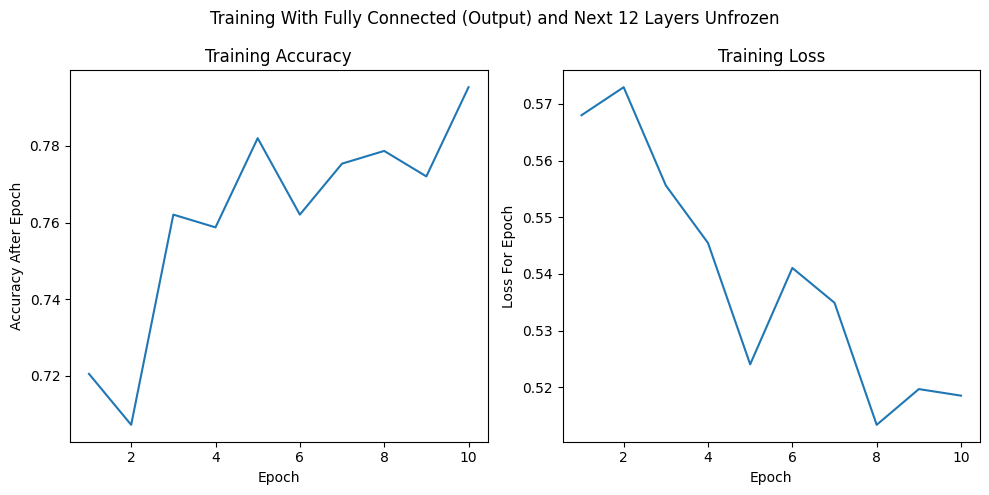

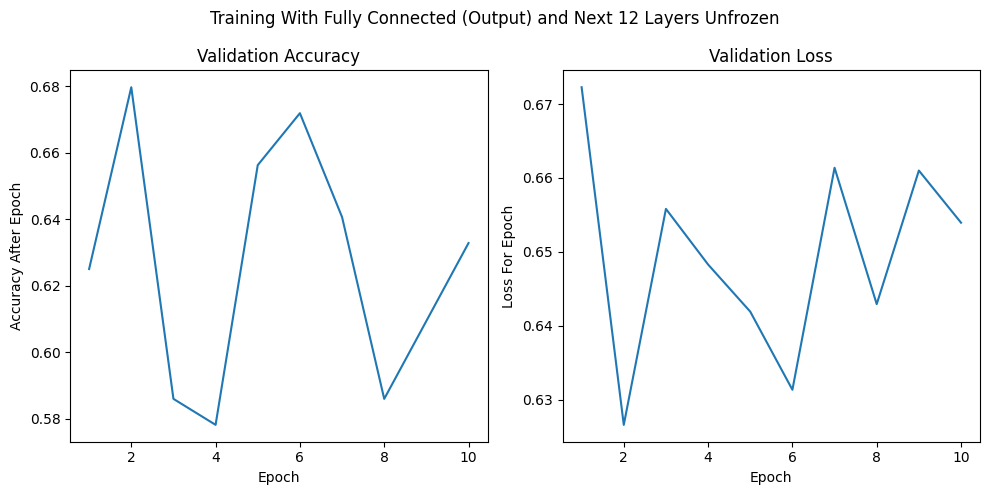

Training Model with Classifier (Output) Layer and Next 13 Layers Unfrozen:

Epoch 1/10:

Training Loss For Epoch 1: 0.5247746563195785
Training Accuracy After Epoch 1: 77.04%

Validation Loss For Epoch 1: 0.6440751883201301
Validation Accuracy After Epoch 1: 58.59%

Epoch 2/10:

Training Loss For Epoch 2: 0.5214325496043619
Training Accuracy After Epoch 2: 75.54%

Validation Loss For Epoch 2: 0.6370014143176377
Validation Accuracy After Epoch 2: 62.50%

Epoch 3/10:

Training Loss For Epoch 3: 0.5068050012017249
Training Accuracy After Epoch 3: 80.20%

Validation Loss For Epoch 3: 0.6204978264868259
Validation Accuracy After Epoch 3: 64.06%

Epoch 4/10:

Training Loss For Epoch 4: 0.49952711023625834
Training Accuracy After Epoch 4: 79.03%

Validation Loss For Epoch 4: 0.6298638684675097
Validation Accuracy After Epoch 4: 60.16%

Epoch 5/10:

Training Loss For Epoch 5: 0.4976495318424682
Training Accuracy After Epoch 5: 80.53%

Validation Loss For Epoch 5: 0.6116949166171253
Validation 

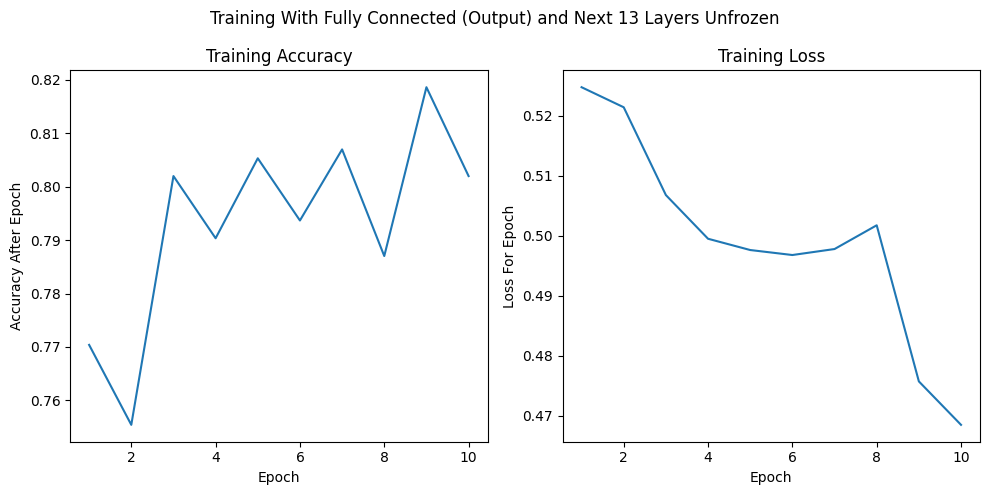

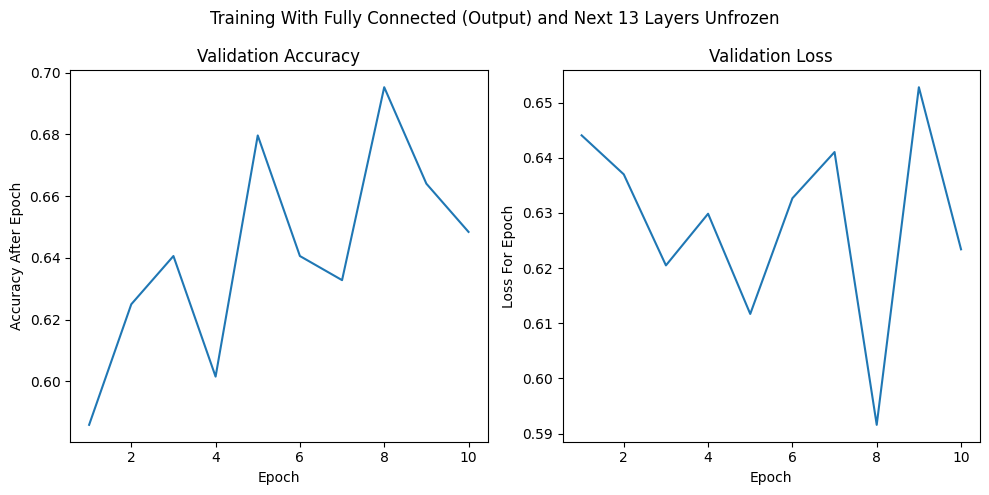

Training Model with Classifier (Output) Layer and Next 14 Layers Unfrozen:

Epoch 1/10:

Training Loss For Epoch 1: 0.4752424403950696
Training Accuracy After Epoch 1: 81.36%

Validation Loss For Epoch 1: 0.6016446384601295
Validation Accuracy After Epoch 1: 67.97%

Epoch 2/10:

Training Loss For Epoch 2: 0.46522392220981107
Training Accuracy After Epoch 2: 84.53%

Validation Loss For Epoch 2: 0.6275146096013486
Validation Accuracy After Epoch 2: 64.84%

Epoch 3/10:

Training Loss For Epoch 3: 0.4664687647200662
Training Accuracy After Epoch 3: 82.70%

Validation Loss For Epoch 3: 0.6174565204419196
Validation Accuracy After Epoch 3: 67.97%

Epoch 4/10:

Training Loss For Epoch 4: 0.44594006232929706
Training Accuracy After Epoch 4: 85.02%

Validation Loss For Epoch 4: 0.6245376812294126
Validation Accuracy After Epoch 4: 64.06%

Epoch 5/10:

Training Loss For Epoch 5: 0.44991294060292936
Training Accuracy After Epoch 5: 85.02%

Validation Loss For Epoch 5: 0.6168361082673073
Validatio

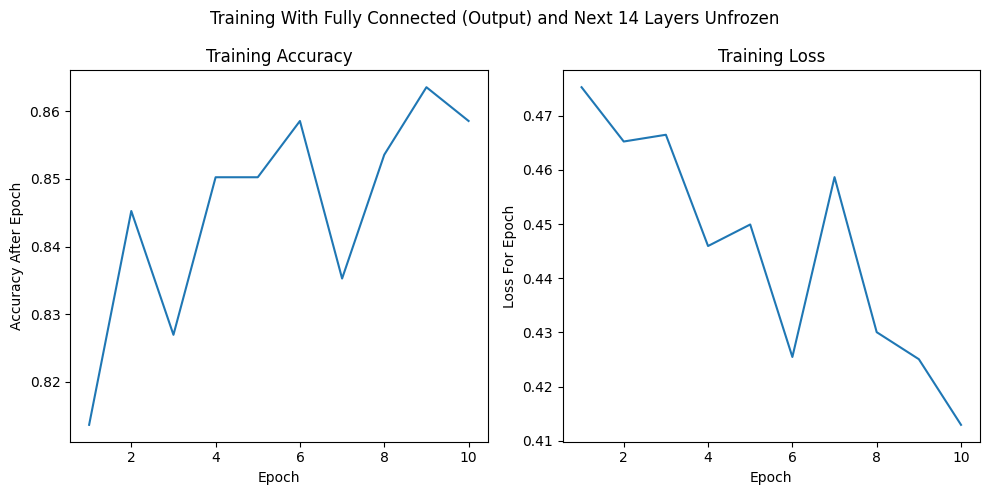

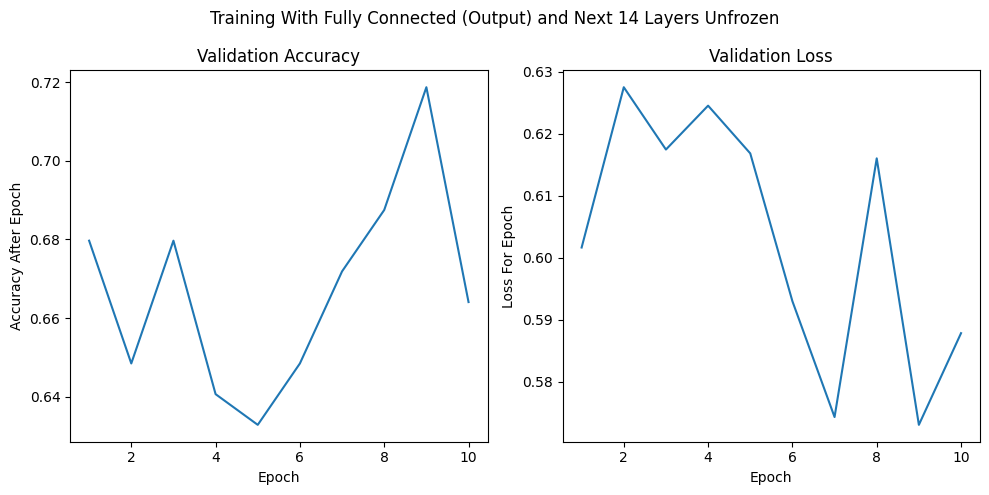

Training Model with Classifier (Output) Layer and Next 15 Layers Unfrozen:

Epoch 1/10:

Training Loss For Epoch 1: 0.4155535637439785
Training Accuracy After Epoch 1: 86.02%

Validation Loss For Epoch 1: 0.5814395644702017
Validation Accuracy After Epoch 1: 69.53%

Epoch 2/10:

Training Loss For Epoch 2: 0.4104918649609196
Training Accuracy After Epoch 2: 85.36%

Validation Loss For Epoch 2: 0.5894461395218968
Validation Accuracy After Epoch 2: 70.31%

Epoch 3/10:

Training Loss For Epoch 3: 0.37573428355318533
Training Accuracy After Epoch 3: 88.85%

Validation Loss For Epoch 3: 0.5612255674786866
Validation Accuracy After Epoch 3: 72.66%

Epoch 4/10:

Training Loss For Epoch 4: 0.3858573066811395
Training Accuracy After Epoch 4: 87.85%

Validation Loss For Epoch 4: 0.6390097416006029
Validation Accuracy After Epoch 4: 66.41%

Epoch 5/10:

Training Loss For Epoch 5: 0.36498036484750057
Training Accuracy After Epoch 5: 89.35%

Validation Loss For Epoch 5: 0.5907199583016336
Validation

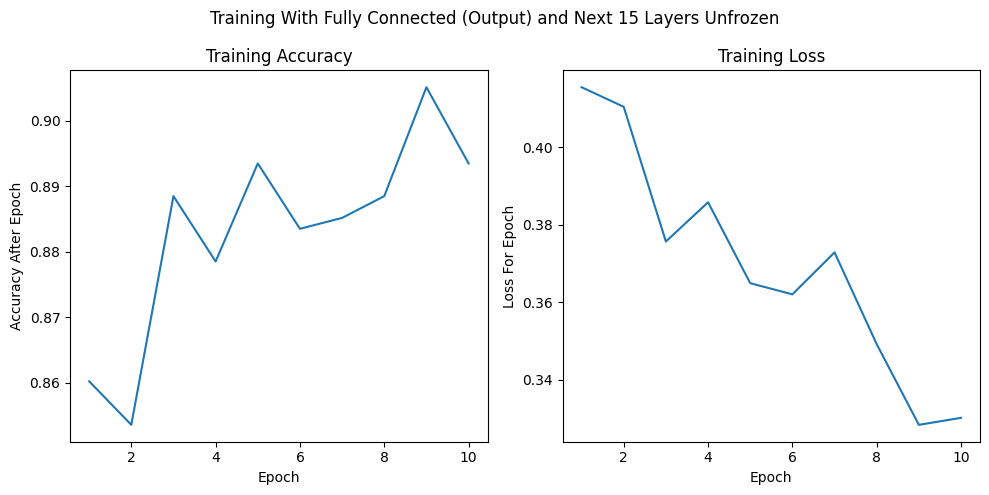

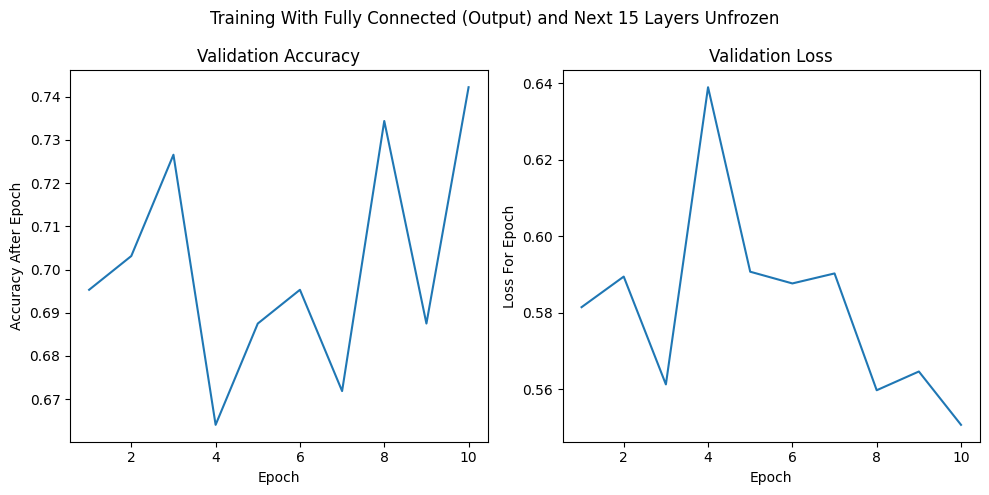

Training Model with Classifier (Output) Layer and Next 16 Layers Unfrozen:

Epoch 1/10:

Training Loss For Epoch 1: 0.3172710376253937
Training Accuracy After Epoch 1: 91.01%

Validation Loss For Epoch 1: 0.573597205337137
Validation Accuracy After Epoch 1: 73.44%

Epoch 2/10:

Training Loss For Epoch 2: 0.29413242338104373
Training Accuracy After Epoch 2: 91.35%

Validation Loss For Epoch 2: 0.5748309632763267
Validation Accuracy After Epoch 2: 71.09%

Epoch 3/10:

Training Loss For Epoch 3: 0.298212155674936
Training Accuracy After Epoch 3: 91.85%

Validation Loss For Epoch 3: 0.5201907409355044
Validation Accuracy After Epoch 3: 75.78%

Epoch 4/10:

Training Loss For Epoch 4: 0.2803066959000268
Training Accuracy After Epoch 4: 93.01%

Validation Loss For Epoch 4: 0.5694790515117347
Validation Accuracy After Epoch 4: 71.88%

Epoch 5/10:

Training Loss For Epoch 5: 0.2686721586843894
Training Accuracy After Epoch 5: 92.35%

Validation Loss For Epoch 5: 0.5552330324426293
Validation Ac

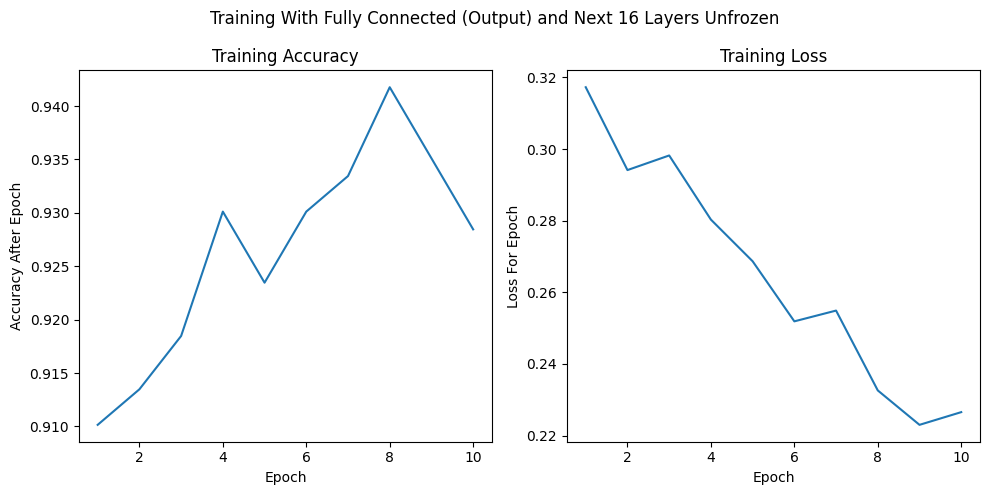

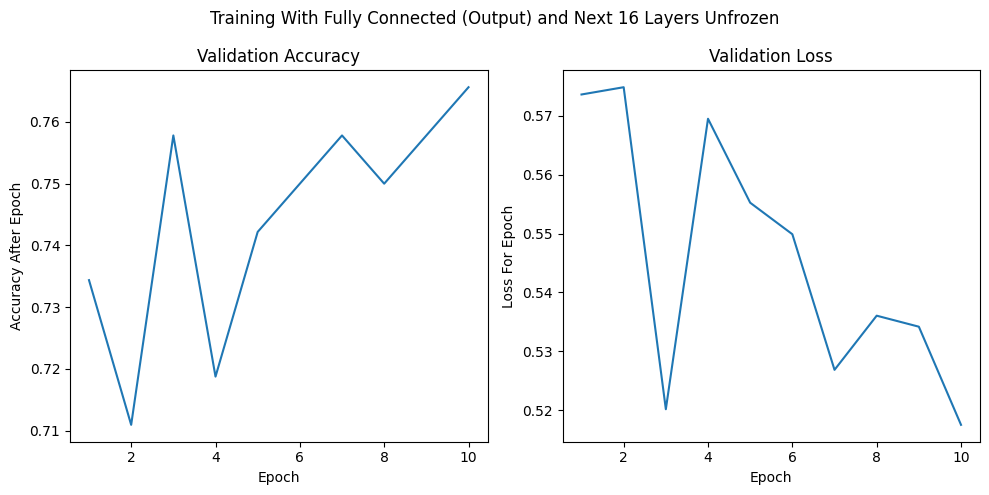

Training Model with Classifier (Output) Layer and Next 17 Layers Unfrozen:

Epoch 1/10:

Training Loss For Epoch 1: 0.22265817981194735
Training Accuracy After Epoch 1: 93.01%

Validation Loss For Epoch 1: 0.5476398440077901
Validation Accuracy After Epoch 1: 75.00%

Epoch 2/10:

Training Loss For Epoch 2: 0.1913614424810235
Training Accuracy After Epoch 2: 95.51%

Validation Loss For Epoch 2: 0.5357079694513232
Validation Accuracy After Epoch 2: 72.66%

Epoch 3/10:

Training Loss For Epoch 3: 0.18028406631480437
Training Accuracy After Epoch 3: 95.51%

Validation Loss For Epoch 3: 0.5658497551921755
Validation Accuracy After Epoch 3: 75.78%

Epoch 4/10:

Training Loss For Epoch 4: 0.17719983124792477
Training Accuracy After Epoch 4: 95.67%

Validation Loss For Epoch 4: 0.5091784349642694
Validation Accuracy After Epoch 4: 77.34%

Epoch 5/10:

Training Loss For Epoch 5: 0.19519519045973777
Training Accuracy After Epoch 5: 93.68%

Validation Loss For Epoch 5: 0.5612900832202286
Validati

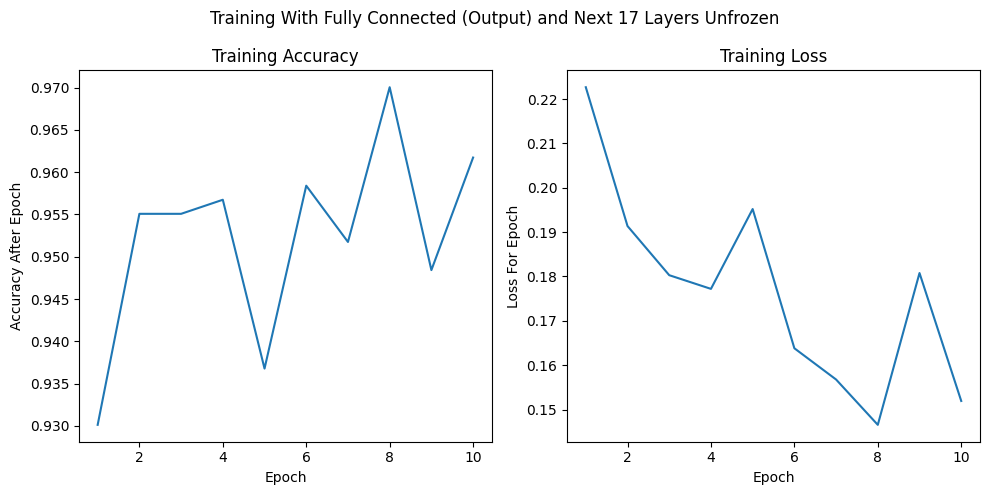

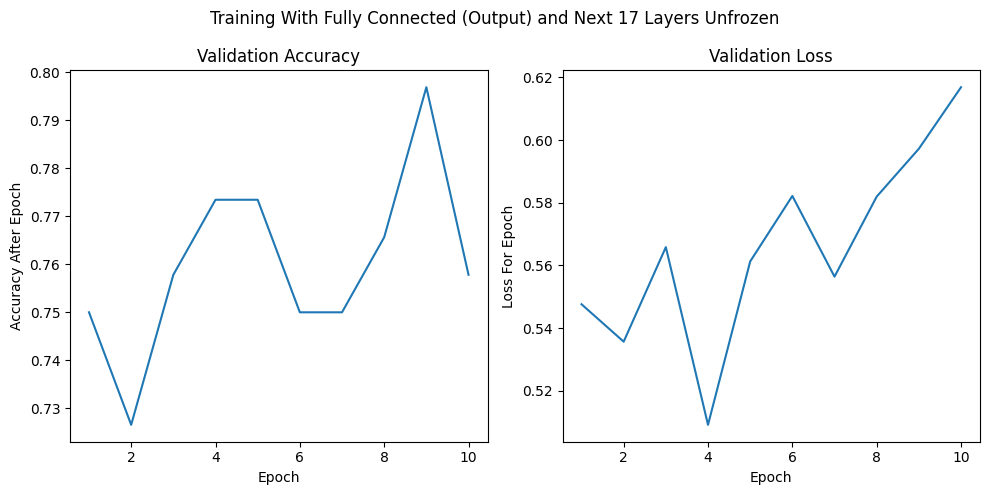

In [3]:
# This block sequentially fine-tunes remaining layers of model

optimizer = optim.Adam(model.parameters(), lr=1e-5) # implements lower learning rate for remaining layers
for i, layer in enumerate(model.features):
    for param in layer.parameters():
        param.requires_grad = True

    print("Training Model with Classifier (Output) Layer and Next {} Layers Unfrozen:\n".format(i+1))
    model, layer_train_acc, layer_train_losses, layer_val_acc, layer_val_losses = train_model(model, dataloader, criter, optimizer, num_epoch)

    layer_description = "Training With Fully Connected (Output) and Next {} Layers Unfrozen".format(i+1)
    plot_learning(num_epoch, layer_train_acc, layer_train_losses, layer_description, dataset="train")
    plot_learning(num_epoch, layer_val_acc, layer_val_losses, layer_description, dataset="val")

Training Model With All Layers Unfrozen:

Epoch 1/10:

Training Loss For Epoch 1: 0.13654312829234438
Training Accuracy After Epoch 1: 96.01%

Validation Loss For Epoch 1: 0.6038609597599134
Validation Accuracy After Epoch 1: 77.34%

Epoch 2/10:

Training Loss For Epoch 2: 0.11676847457439452
Training Accuracy After Epoch 2: 96.84%

Validation Loss For Epoch 2: 0.5768062554998323
Validation Accuracy After Epoch 2: 76.56%

Epoch 3/10:

Training Loss For Epoch 3: 0.10396658917098692
Training Accuracy After Epoch 3: 97.84%

Validation Loss For Epoch 3: 0.6398035315214656
Validation Accuracy After Epoch 3: 75.78%

Epoch 4/10:

Training Loss For Epoch 4: 0.12001695028024287
Training Accuracy After Epoch 4: 96.84%

Validation Loss For Epoch 4: 0.6442345775431022
Validation Accuracy After Epoch 4: 78.12%

Epoch 5/10:

Training Loss For Epoch 5: 0.12272286155693443
Training Accuracy After Epoch 5: 95.51%

Validation Loss For Epoch 5: 0.6872838600538671
Validation Accuracy After Epoch 5: 77.34%

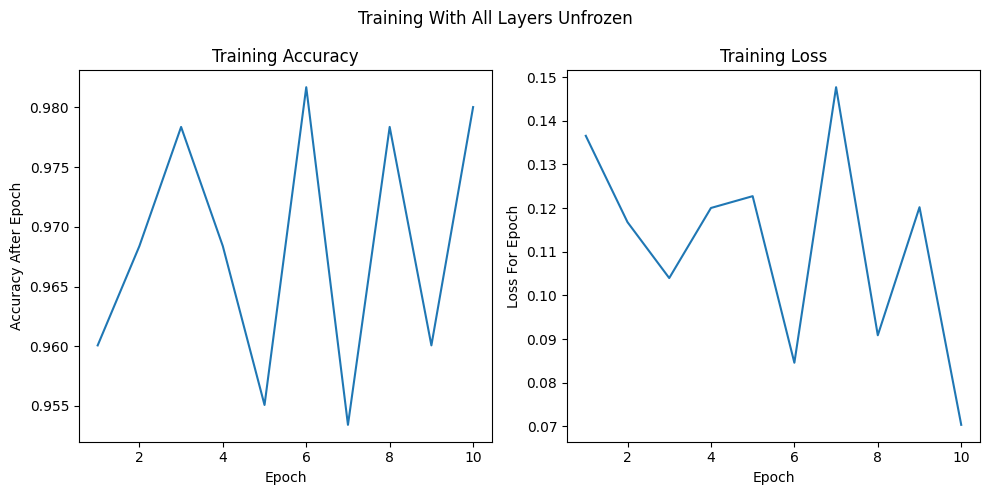

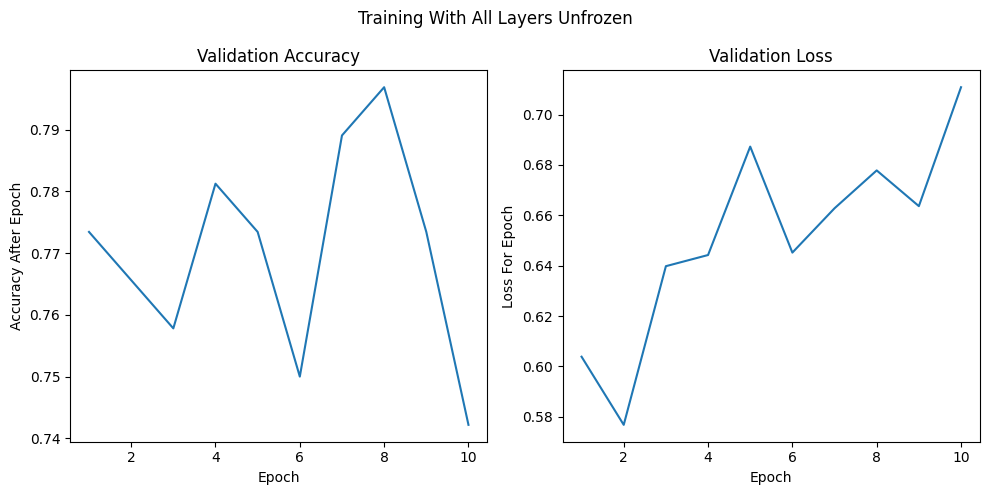

In [4]:
# This block fine-tunes input layer (sequential conv2D layer) of the model

optimizer = optim.Adam(model.parameters(), lr=1e-5) # Lower learning rate from 1e-4 to 1e-5 as learning plateaus

for param in model.parameters(): # Unfreeze all layers to capture all previously unfrozen layers and the final convolutional layer
    param.requires_grad = True

print("Training Model With All Layers Unfrozen:\n")

model, layer_train_acc, layer_train_losses, layer_val_acc, layer_val_losses = train_model(model, dataloader, criter, optimizer, num_epoch)

layer_description = "Training With All Layers Unfrozen"
plot_learning(num_epoch, layer_train_acc, layer_train_losses, layer_description, dataset="train")
plot_learning(num_epoch, layer_val_acc, layer_val_losses, layer_description, dataset="val")

In [5]:
# This block performs analysis and comparisons using the final newly trained model

model.eval()

output_list = []
correct = 0
total = 0
loss_trained = 0
with torch.no_grad():
    for waveforms, labels, labels_num in test_loader:
        waveforms, labels_num = waveforms.to(device), labels_num.to(device)
        outputs = model(waveforms)
        _, predicted = torch.max(outputs, 1)
        total+= labels_num.size(0)
        correct+= (predicted == labels_num).sum().item()
        output_list.append(outputs)
        loss = criter(outputs,labels_num)
        loss_trained += loss.item() * waveforms.size(0)
        

print("{}% Test Accuracy With Newly Trained Model".format(correct/total*100))
print("Test Set Loss of {} With Newly Trained Model".format(loss_trained))



80.76923076923077% Test Accuracy With Newly Trained Model
Test Set Loss of 73.92512500286102 With Newly Trained Model


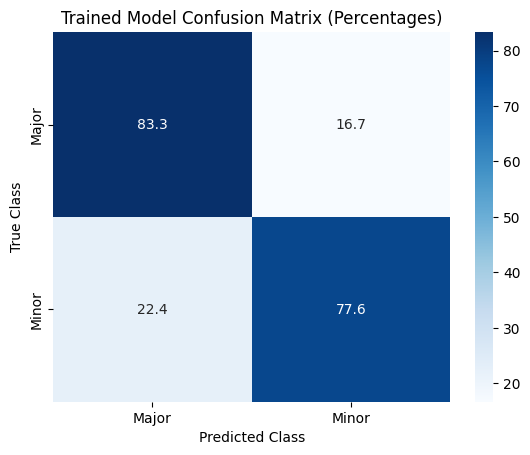

              precision    recall  f1-score   support

       Major       0.82      0.83      0.83        72
       Minor       0.79      0.78      0.78        58

    accuracy                           0.81       130
   macro avg       0.81      0.80      0.81       130
weighted avg       0.81      0.81      0.81       130



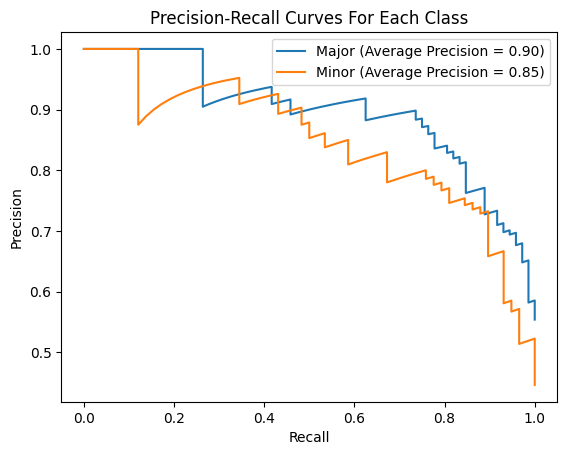

In [6]:
# This block generates the confusion matrix, classification report, and plots the PR curves for each class

from sklearn.metrics import classification_report, precision_recall_curve, average_precision_score

model.eval()

class_names = ["Major", "Minor"]

label_prob = [] # list of all predicted classes probabilities
label_true = [] # list of true class labels
label_pred = [] # list of predicted class labels

with torch.no_grad():
    for waveforms, labels, labels_num in test_loader:
        waveforms, labels_num = waveforms.to(device), labels_num.to(device)
        outputs = model(waveforms)
        probability = torch.softmax(outputs, dim = 1)
        _, pred = torch.max(outputs,1)
        #label_pred.extend(pred.cpu().numpy())
        #label_prob.extend(probability.cpu().numpy())
        #label_true.extend(labels.cpu().numpy())

        label_pred.extend(pred)
        label_prob.extend(probability)
        label_true.extend(labels_num)

label_prob = np.array(label_prob)
label_true = np.array(label_true)
label_pred = np.array(label_pred)

model_confusion = confusion_matrix(label_true, label_pred)
model_confusion_percent = model_confusion.astype('float') / model_confusion.sum(axis=1)[:, np.newaxis] * 100

plt.figure()
sns.heatmap(model_confusion_percent, cmap="Blues", annot=True, fmt = '.1f', xticklabels = class_names, yticklabels = class_names)
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.title("Trained Model Confusion Matrix (Percentages)")
plt.show()

cr = classification_report(label_true, label_pred, target_names = class_names)
print(cr)

label_true_arr = np.eye(len(class_names))[label_true]

plt.figure()
for i, class_name in enumerate(class_names):
    precision, recall, _ = precision_recall_curve(label_true_arr[:,i], label_prob[:,i])
    average_precision = average_precision_score(label_true_arr[:,i], label_prob[:,i])

    
    plt.plot(recall, precision, label = "{} (Average Precision = {:.2f})".format(class_name, average_precision))

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves For Each Class")
plt.legend()
plt.show()